# Classificaton Fine-tuning

La siguiente tarea consiste en entrenar un modelo de HuggingFace (HF) para realizar la _task_ de _classification_. El dataset para entrenar dicho modelo está predefinido. Sin embargo, el modelo, el tokenizador y el trainer pueden ser totalmente personalizados. Es decir, que tendréis que realizar un trabajo de investigación, de prueba y error, para poder ir aprendiendo y ganando destreza con HF.

Recomendaciones:
- Durante este proceso, tendréis muchas dudas y encontraréis muchos errores. Tratad de resolverlas primero por vuestra cuenta, enteniendo la causa del error. Después con recursos online. Y, finalmente, siempre está el foro, que puede ser utilizado de forma participativa.
- No dejeis la tarea para el último día. Los modelos tardan en entrenar. Los problemas no se resuelven en la primera iteración.

Finalmente, se pide:
- Limpieza rigurosa en la presentación del notebook.
- El notebook se entrega con todas las celdas ejecutadas.
- Los comentarios (opcionales), mejor sobre el código con '#'.

Ánimo!

## Dataset

A continuación, descargarás un DatasectDict llamado _glue_ (_split mnli_). La target es la columna llamada _label_.

In [1]:
!pip install datasets
!pip install transformers
!pip pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [2]:
from datasets import load_dataset

ds = load_dataset("glue", "mnli") #https://huggingface.co/datasets/nyu-mll/glue/viewer/mnli/train
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

Lo primero que tendrás que hacer es construir un DatasetDict nuevo, llamado **ds_tarea**, que filtre el anterior DatasetDict para:
- quedarse con los registros que tengan el contenido de la columna _premise_ con menos (estrictamente) de 20 caracteres.
- que solo tenga los Datasets de _train_ y _validation_matched_

In [3]:
ds_tarea = None

### BEGIN SOLUTION
from datasets import DatasetDict

#primero voy a crear mi filtro
def filtro(ejemplo):
    return len(ejemplo['premise']) < 20

#ahora voy a aplicar el filtro a los dos conjuntos de datos
train_filtrado = ds['train'].filter(filtro)
validation_matched_filtrado = ds['validation_matched'].filter(filtro)

#creo el DatasetDict que se me pide
ds_tarea = DatasetDict({
    'train': train_filtrado,
    'validation_matched': validation_matched_filtrado,
})
### END SOLUTION

ds_tarea

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
})

In [4]:
# Celda de control

assert len(ds_tarea['train']) == 13635
assert len(ds_tarea['validation_matched']) == 413
assert set(ds_tarea.keys()) == {'train', 'validation_matched'}

## EDA

Si tenéis que realizar alguna exploración del datos, utilizad esta sección.

In [5]:
#label 0 es implicacion, label 1 es neutra, label 2 es contradiccion
#paso los subdatasets a pandas para poder hacer el analisis
print(ds_tarea)
import pandas as pd
df_train = pd.DataFrame(ds_tarea['train'])
df_val = pd.DataFrame(ds_tarea['validation_matched'])

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
})


In [6]:
print(df_train.head())
print(df_val.head())
print(df_train.info())
print(df_val.info())
print(df_train.describe())
print(df_val.describe())
print(df_train.nunique())
print(df_val.nunique())
print(df_train.isnull().sum())
print(df_val.isnull().sum())
print(df_train['label'].value_counts())
print(df_val['label'].value_counts())

               premise                                   hypothesis  label  \
0   Gays and lesbians.                               Heterosexuals.      2   
1  Were they in there?           Were they supposed to be in there?      1   
2     She smiled back.  She was so happy she couldn't stop smiling.      1   
3     In full costume.              He is wearing a mascot costume.      1   
4   Ca'daan continued.                     Ca'daan refused to stop.      1   

   idx  
0    8  
1   33  
2   48  
3   59  
4   77  
               premise                       hypothesis  label  idx
0       Tuppence rose.   Tuppence floated into the air.      1   65
1        What changed?                 What was unique?      1   77
2         Then he ran.          He ran like an athlete.      1   90
3  right after the war        Just after the war ended.      0  127
4   Then I considered.  Afterwards, I thought about it.      0  146
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13635 entries, 0 to

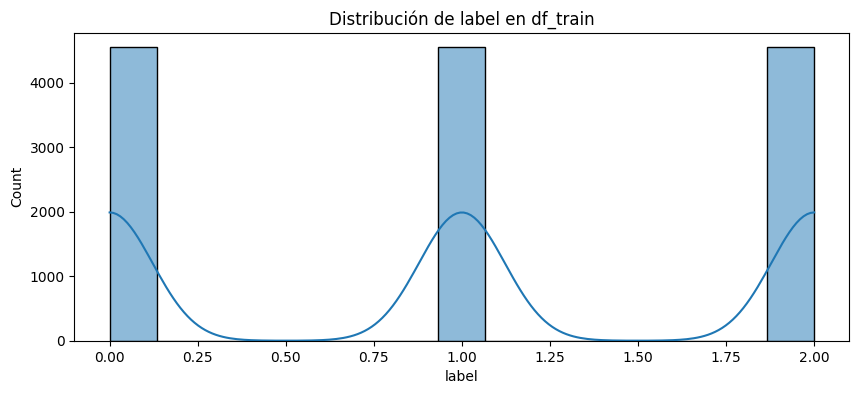

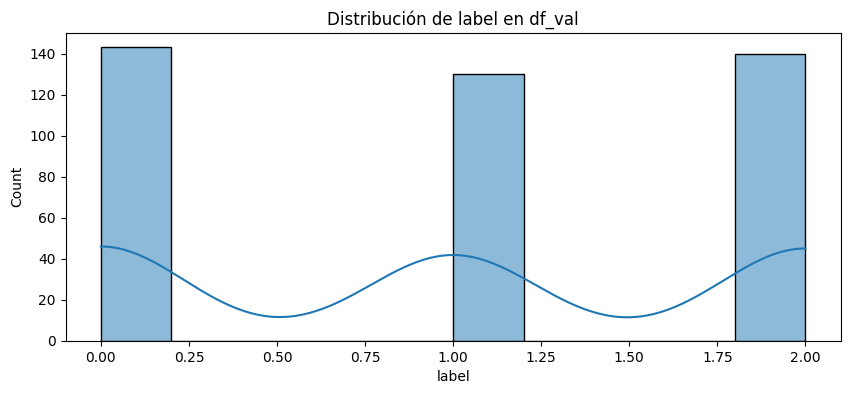

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 4))
plt.title(f'Distribución de label en df_train')
sns.histplot(df_train['label'], kde=True)
plt.show()
plt.figure(figsize=(10, 4))
plt.title(f'Distribución de label en df_val')
sns.histplot(df_val['label'], kde=True)
plt.show()

## Model y Tokenizer

Se pide guardar el modelo y el tokenizador en las variables _model_ y _tokenizer_.
Aunque no se utilicen hasta más adelante, declaradlos en esta sección.

In [8]:
tokenizer = None
model = None

### BEGIN SOLUTION
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

### END SOLUTION

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Feature Engineering

En esta parte, tenéis que preparar el dataset de entrada al modelo. Principalmente, tendréis que tokenizar las frases. De esta forma, crearéis columnas como _input_ids_, _attention_mask_... No obstante, depende del modelo elegido. Así pues, tendréis que investigar un poco.

Al finalizar la sección, bien si modificais el DatasectDict, bien si no lo modificáis, lo guardaréis en __ds_tarea_featured__.

In [9]:
ds_tarea_featured = ds_tarea # Esta línea tiene sentido en caso de que no se modifique el dataset

### BEGIN SOLUTION
def tokenize_and_create_features(example):
    tokenized = tokenizer(
        example["premise"],
        example["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    return tokenized

ds_tarea_featured = {
    split: ds_tarea[split].map(tokenize_and_create_features, batched=True)
    for split in ds_tarea.keys()
}
### END SOLUTION

ds_tarea_featured

Map:   0%|          | 0/13635 [00:00<?, ? examples/s]

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

{'train': Dataset({
     features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
     num_rows: 13635
 }),
 'validation_matched': Dataset({
     features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
     num_rows: 413
 })}

In [10]:
# Celda de control

assert len(ds_tarea_featured['train']) == 13635
assert len(ds_tarea_featured['validation_matched']) == 413

## Fine-tuning

Para poder evaluar el modelo a lo largo del proceso y no esperar a tener toda la ejecución completa (que podría durar horas), se propone la creación de una métrica que muestre por pantalla la evolución del entrenamiento.

Esta métrica se declara en una función, llamada en este caso _compute_metrics_ y se le pide a los argumentos y al trainer que calculen la métrica al final de cada _epoch_ con el _evaluation_dataset_.

In [11]:
from datasets import load_metric

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

A continuación, de forma libre se pide entrenar un modelo de HuggingFace deseado. Se pide usar un Trainer de HuggingFace que tenga los siguientes argumentos como mínimo (puede haber más argumentos en todas las variables):

In [12]:
from transformers import TrainingArguments, Trainer

### BEGIN SOLUTION
args = TrainingArguments(
    output_dir='./finetuned1',
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tarea_featured["train"],
    eval_dataset=ds_tarea_featured["validation_matched"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
### END SOLUTION

A continuación se entrena el modelo. Se pide no modificar esta celda, solo ejecutar.

In [13]:
# Esta celda, celda tiene que estar ejecutada en la entrega

from time import time

start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.743200,0.642632,0.733656
2,0.520900,0.584881,0.782082
3,0.354600,0.750821,0.801453


<ipython-input-11-3b44ea28a3f1>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
>>>>>>>>>>>>> elapsed time: 60m


In [15]:
# Esta celda, celda tiene que estar ejecutada en la entrega
# Se espera un eval_accuracy superior a 0.75
# A mayor accuracy no hay mayor nota, con superar el umbral de 0.75 es suficiente

results = trainer.evaluate()
final_eval_accuracy = results.get("eval_accuracy")

print(f"Final Eval Accuracy: {final_eval_accuracy:.2f}")

Final Eval Accuracy: 0.80
